## Install Requirements

In [ ]:
!pip install contractions
!pip install psutil
!pip install pytorch-transformers
!pip install transformers
!pip install keras-tuner --upgrade
!pip install torch torchvision  torchaudio -f https://download.pytorch.org/whl/torch_stable.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 10.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_6

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Load and Clean Data

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('data_supervised.csv')
#df = pd.read_csv('df_lemmatized.csv',keep_default_na=False)
gender_label = pd.read_csv('target_supervised.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import re
import nltk
import string
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopword = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()


def initial_clean(text):
      # lowercasing
      text = str(text).lower()
      # fix contractions
      text = contractions.fix(text)
      # remove urls
      url_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
      text = re.sub(url_pattern, "", text)
      # remove punctuations
      ##text  = "".join([char if char not in string.punctuation else " " for char in text])
      return text

#The goal of lemmatization is to normalize words so that variations of the same word
#are treated as the same word for analysis purposes.

def lemmatize(text_tokens):
    tokens = [lemmatizer.lemmatize(token) for token in text_tokens if token.isalpha() and token not in stopword ]
    return tokens

def clean(text):
    if text=="":
        return text
    text = initial_clean(text)
    # tokenization
    text_tokens = word_tokenize(text)
    text_tokens = lemmatize(text_tokens)
    text = ' '.join(text_tokens)
    # remove extra spaces
    text = re.sub(' +', ' ', text)
    return text
df['cleaned_comment'] = df['body'].apply(lambda row: clean(row))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df.drop(columns=['body'],inplace=True)
df.to_csv('df_lemmatized.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296042 entries, 0 to 296041
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   author           296042 non-null  object 
 1   subreddit        296042 non-null  object 
 2   created_utc      296042 non-null  float64
 3   cleaned_comment  296042 non-null  object 
dtypes: float64(1), object(3)
memory usage: 9.0+ MB


## Section4.2 - Subreddit Matrix




In [ ]:
grouped_comments= df.groupby('author')['cleaned_comment'].apply(lambda x: ' '.join(x)).reset_index()
grouped_comments_labeled = pd.merge(grouped_comments, gender_label ,on="author")

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

def get_subreddit_matrix(df, grouped_comments):
  # Create a list of unique users and subreddits
  unique_authors = grouped_comments['author']
  unique_subreddits = df['subreddit'].unique()

  author_row_map = {author: idx for idx, author in enumerate(unique_authors)}
  # Initialize a user-subreddit matrix
  author_subreddit_matrix = np.zeros((len(unique_authors), len(unique_subreddits)))

  # Populate the matrix with the number of times each user has posted in each subreddit
  for _, row in df.iterrows():
      author_index = author_row_map[row['author']]
      subreddit_index = np.where(unique_subreddits == row['subreddit'])[0][0]
      author_subreddit_matrix[author_index, subreddit_index] += 1

  # Normalize each row of the matrix
  author_subreddit_matrix_normalized = author_subreddit_matrix / author_subreddit_matrix.sum(axis=1, keepdims=True)
  return author_row_map, author_subreddit_matrix_normalized

author_row_map, author_subreddit_matrix_normalized = get_subreddit_matrix(df,grouped_comments)

In [ ]:
# Determine the number of components required
svd = TruncatedSVD(n_components=1000)
svd.fit(author_subreddit_matrix_normalized)

# Access the explained variance ratio for each component
explained_variance_ratio = svd.explained_variance_ratio_

# Compute the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

n_components = np.argmax(cumulative_variance_ratio > 0.95) + 5
print(n_components)



806


In [ ]:
svd = TruncatedSVD(n_components=n_components)
author_subreddit_matrix_reduced = svd.fit_transform(author_subreddit_matrix_normalized)
svd.explained_variance_ratio_.cumsum()[-1]

0.9503154189596873

In [ ]:
#np.save('author_subreddit_matrix_reduced.npy',author_subreddit_matrix_reduced)

In [ ]:
# Load saved matrix
author_row_map = {author: idx for idx, author in enumerate(grouped_comments['author'])}
author_subreddit_matrix_reduced = np.load('author_subreddit_matrix_reduced.npy')

## Section4.3 Encode and Prepare Data

In [ ]:
import gc
import torch

from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def embed_text(df, max_length=512):
    #tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
    #model = LongformerModel.from_pretrained('allenai/longformer-base-4096')
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    encoded_texts = []
    for text in tqdm(df['cleaned_comment']):
        inputs = tokenizer(
            text,
            return_tensors='pt',
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True
          )
        with torch.no_grad():
          outputs = model(**inputs)
        # embedding of cls
        #sentence_embedding = outputs[0][:,0,:].numpy()
        # mean pooling
        sentence_embedding = mean_pooling(outputs, inputs['attention_mask'])
        encoded_texts.append(sentence_embedding)
        del inputs, outputs
        gc.collect()
    return encoded_texts

sentence_embeddings_all = []
for i in range(0, 5000, 1000):
  sentence_embeddings = np.array(embed_text(grouped_comments_labeled[i:i+1000]))
  np.savez_compressed(f'sentence_embeddings_{i}.npz',sentence_embeddings)
  sentence_embeddings_all.append(sentence_embeddings)

#NOTE: Due to RAM limitation we've splitted the data, embedded each split and then concatenated them all
#NOTE: DistillBert is smaller and faster version of BERT model with 97% of BERT's performance
#NOTE: we've tried both mean_pooling and [cls] embedding to encode the text. The former one outperformed the latter one.

100%|██████████| 1000/1000 [21:33<00:00,  1.29s/it]


In [ ]:
#embeddings_all = np.concatenate(tuple(sentence_embeddings_all))
#embeddings_all = embeddings_all.squeeze()
#np.savez_compressed(f'embeddings_all.npz',embeddings_all)
embeddings_all=np.load('embeddings_all.npz')['arr_0']

In [ ]:
embeddings_all.shape

(5000, 768)

In [ ]:
input_matrix = np.concatenate((author_subreddit_matrix_reduced,embeddings_all),axis=1)

### Split Train Test data

In [ ]:
from sklearn.model_selection import train_test_split

combined_data = list(zip(grouped_comments_labeled.values, input_matrix))

# Split the combined data into training and testing sets
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42)

# Unzip the training and testing sets into separate DataFrames and TF-IDF matrices
train_df, X_train = zip(*train_data)
train_df = pd.DataFrame(train_df, columns=grouped_comments_labeled.columns)
X_train = np.array(X_train)
y_train = np.array(train_df['gender'])

test_df, X_test = zip(*test_data)
test_df = pd.DataFrame(test_df, columns=grouped_comments_labeled.columns)
X_test = np.array(X_test)
y_test = np.array(test_df['gender'])


## Section4.4 Neural Network Model

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import roc_auc_score

logit = LogisticRegression(C=1, max_iter=100,n_jobs=4)
logit.fit(X_train, y_train)
cv_scores = cross_val_score(logit, X_train, y_train, cv=5, scoring='accuracy')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
y_pred = logit.predict(X_test)
roc_auc_score(y_test, logit.predict_proba(X_test)[:, 1])

0.8424817872753764

In [ ]:
!pip install psutil

import psutil
import os
import gc

def clear_memory():
    process = psutil.Process(os.getpid())
    print("Memory used before clearing:", process.memory_info().rss / 1024 / 1024, "MB")
    gc.collect()
    process = psutil.Process(os.getpid())
    print("Memory used after clearing:", process.memory_info().rss / 1024 / 1024, "MB")

# Call this function whenever you want to clear memory
clear_memory()

Memory used before clearing: 6597.01953125 MB
Memory used after clearing: 6597.05859375 MB


### Base

In [ ]:
import numpy as np
import keras
import keras_tuner

from keras import regularizers
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Balancing class weights
initial_bias = np.log([sum(y_train)/(len(y_train)-sum(y_train))])
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


model = Sequential([
        Dense(128, activation='relu',input_shape=(input_matrix.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid',bias_initializer=keras.initializers.Constant(initial_bias))
    ])


model.compile(optimizer=Adam(5e-5), loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc')])
model.summary()

In [ ]:
class PrintMetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\nEpoch:", epoch+1)
        print("Train Loss:", logs['loss'])
        print("Val Loss:", logs['val_loss'])
        print("Train Accuracy:", logs['accuracy'])
        print("Val Accuracy:", logs['val_accuracy'])

print_metrics_callback = PrintMetricsCallback()

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True
    )
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=300, batch_size=8,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[print_metrics_callback])

# Evaluate the model on test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print performance metrics
print(classification_report(y_test, y_pred_binary))
print("AUC Score:", roc_auc_score(y_test, y_pred))

Epoch 1/300
445/450 [============================>.] - ETA: 0s - loss: 1.6474 - accuracy: 0.7267 - auc: 0.5235 - prc: 0.2881
Epoch: 1
Train Loss: 1.6460988521575928
Val Loss: 1.4016119241714478
Train Accuracy: 0.7269444465637207
Val Accuracy: 0.7799999713897705
450/450 [==============================] - 10s 14ms/step - loss: 1.6461 - accuracy: 0.7269 - auc: 0.5224 - prc: 0.2865 - val_loss: 1.4016 - val_accuracy: 0.7800 - val_auc: 0.5784 - val_prc: 0.3167
Epoch 2/300
447/450 [============================>.] - ETA: 0s - loss: 1.5710 - accuracy: 0.6904 - auc: 0.5119 - prc: 0.2824
Epoch: 2
Train Loss: 1.5700352191925049
Val Loss: 1.4258160591125488
Train Accuracy: 0.690833330154419
Val Accuracy: 0.7799999713897705
450/450 [==============================] - 5s 11ms/step - loss: 1.5700 - accuracy: 0.6908 - auc: 0.5114 - prc: 0.2813 - val_loss: 1.4258 - val_accuracy: 0.7800 - val_auc: 0.5831 - val_prc: 0.3426
Epoch 3/300
447/450 [============================>.] - ETA: 0s - loss: 1.5259 - accu

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()
  plt.show()
plot_loss(history)

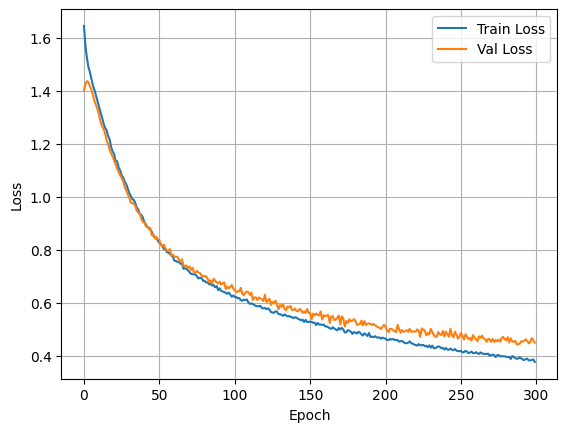

In [ ]:
plot_loss(history)

The model is still learning so, we continue the learning

In [ ]:
history2 = model.fit(
    X_train, y_train,
    epochs=200, batch_size=8,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[print_metrics_callback])


Epoch 1/100
450/450 [==============================] - ETA: 0s - loss: 0.3298 - accuracy: 0.8872 - auc: 0.9544 - prc: 0.8913
Epoch: 1
Train Loss: 0.32984334230422974
Val Loss: 0.41229796409606934
Train Accuracy: 0.8872222304344177
Val Accuracy: 0.8525000214576721
450/450 [==============================] - 6s 14ms/step - loss: 0.3298 - accuracy: 0.8872 - auc: 0.9544 - prc: 0.8913 - val_loss: 0.4123 - val_accuracy: 0.8525 - val_auc: 0.8713 - val_prc: 0.7655
Epoch 2/100
446/450 [============================>.] - ETA: 0s - loss: 0.3278 - accuracy: 0.8899 - auc: 0.9554 - prc: 0.8900
Epoch: 2
Train Loss: 0.3294997215270996
Val Loss: 0.420179545879364
Train Accuracy: 0.8897222280502319
Val Accuracy: 0.8525000214576721
450/450 [==============================] - 4s 9ms/step - loss: 0.3295 - accuracy: 0.8897 - auc: 0.9548 - prc: 0.8897 - val_loss: 0.4202 - val_accuracy: 0.8525 - val_auc: 0.8708 - val_prc: 0.7670
Epoch 3/100
448/450 [============================>.] - ETA: 0s - loss: 0.3288 - accu

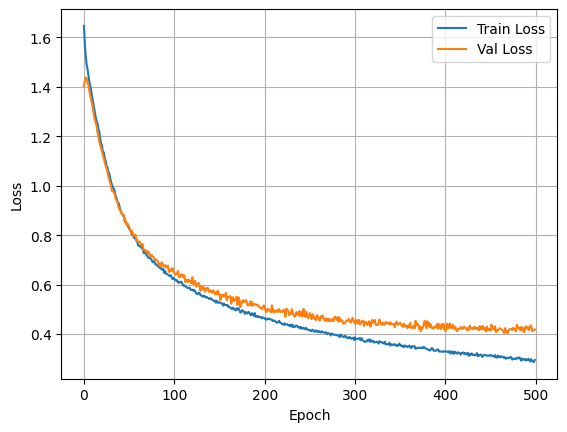

In [ ]:
history.history['loss'].extend(history2.history['loss'])
history.history['val_loss'].extend(history2.history['val_loss'])
plot_loss(history)

In [ ]:
# Evaluate the model on test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print performance metrics
print(classification_report(y_test, y_pred_binary))
print("AUC Score:", roc_auc_score(y_test, y_pred))

32/32 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       710
           1       0.68      0.73      0.71       290

    accuracy                           0.82      1000
   macro avg       0.79      0.80      0.79      1000
weighted avg       0.83      0.82      0.83      1000

AUC Score: 0.8744924720738222


It has converged at epoch ~400, So we should stop training at epoch 400 for this configuration of MLP model. Note that the validation loss is not going up yet.

Epoch 1/50
446/450 [============================>.] - ETA: 0s - loss: 0.6412 - accuracy: 0.6646 - auc: 0.7126 - prc: 0.4870
Epoch: 1
Train Loss: 0.6400520205497742
Val Loss: 0.5669969320297241
Train Accuracy: 0.6652500033378601
Val Accuracy: 0.75
450/450 [==============================] - 6s 10ms/step - loss: 0.6401 - accuracy: 0.6653 - auc: 0.7129 - prc: 0.4864 - val_loss: 0.5670 - val_accuracy: 0.7500 - val_auc: 0.7942 - val_prc: 0.5294
Epoch 2/50
450/450 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.7425 - auc: 0.8073 - prc: 0.6155
Epoch: 2
Train Loss: 0.5423250794410706
Val Loss: 0.6275832653045654
Train Accuracy: 0.7425000071525574
Val Accuracy: 0.6600000262260437
450/450 [==============================] - 5s 11ms/step - loss: 0.5423 - accuracy: 0.7425 - auc: 0.8073 - prc: 0.6155 - val_loss: 0.6276 - val_accuracy: 0.6600 - val_auc: 0.8199 - val_prc: 0.6593
Epoch 3/50
448/450 [============================>.] - ETA: 0s - loss: 0.5107 - accuracy: 0.7595 - au

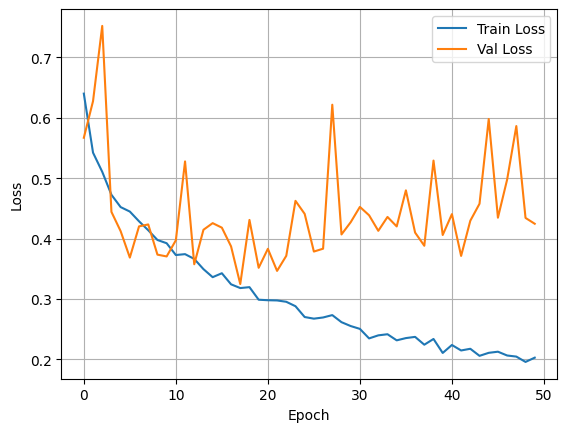

In [ ]:
model = Sequential([
        Dense(128, activation='relu', input_shape=(input_matrix.shape[1],)),
        Dropout(0.5),
        #Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        #Dropout(0.3),
        Dense(1, activation='sigmoid',bias_initializer=keras.initializers.Constant(initial_bias))
    ])


model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=METRICS)

history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=8,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[print_metrics_callback])
plot_loss(history)

For this configuration we need to stop training at epoch 10, where the validation loss is going up and them model is getting overfitted

In [ ]:
# Evaluate the model on test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print performance metrics
print(classification_report(y_test, y_pred_binary))
print("AUC Score:", roc_auc_score(y_test, y_pred))

32/32 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       710
           1       0.72      0.63      0.67       290

    accuracy                           0.82      1000
   macro avg       0.79      0.77      0.78      1000
weighted avg       0.82      0.82      0.82      1000

AUC Score: 0.8627367654201068


In [ ]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=METRICS)

history = model.fit(
    X_train, y_train,
    epochs=10, batch_size=8,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[print_metrics_callback])

Epoch 1/10
447/450 [============================>.] - ETA: 0s - loss: 0.1942 - accuracy: 0.9248 - auc: 0.9674 - prc: 0.9299
Epoch: 1
Train Loss: 0.19472378492355347
Val Loss: 0.5157363414764404
Train Accuracy: 0.9242500066757202
Val Accuracy: 0.8050000071525574
450/450 [==============================] - 3s 5ms/step - loss: 0.1947 - accuracy: 0.9243 - auc: 0.9673 - prc: 0.9293 - val_loss: 0.5157 - val_accuracy: 0.8050 - val_auc: 0.8488 - val_prc: 0.7039
Epoch 2/10
442/450 [============================>.] - ETA: 0s - loss: 0.1860 - accuracy: 0.9330 - auc: 0.9798 - prc: 0.9516
Epoch: 2
Train Loss: 0.18497933447360992
Val Loss: 0.5372897982597351
Train Accuracy: 0.933055579662323
Val Accuracy: 0.8174999952316284
450/450 [==============================] - 2s 4ms/step - loss: 0.1850 - accuracy: 0.9331 - auc: 0.9800 - prc: 0.9522 - val_loss: 0.5373 - val_accuracy: 0.8175 - val_auc: 0.8568 - val_prc: 0.7141
Epoch 3/10
448/450 [============================>.] - ETA: 0s - loss: 0.1926 - accuracy

In [ ]:
# Evaluate the model on test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print performance metrics
print(classification_report(y_test, y_pred_binary))
print("AUC Score:", roc_auc_score(y_test, y_pred))

32/32 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       710
           1       0.69      0.68      0.69       290

    accuracy                           0.82      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.82      0.82      0.82      1000

AUC Score: 0.8612190383681398


## Section4.5 Hyperparameter tuning

### Keras Tuner

In [ ]:

def tuner_make_model(hp,  metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = keras.initializers.Constant(output_bias)
  model = keras.Sequential()
  model.add(Dense(
      hp.Choice('units', [64, 128,256,512]),
      activation='relu')
  )
  model.add(keras.layers.Dropout(hp.Choice('dropout_rate', values=[0.3, 0.5])))
  '''
  model.add(Dense(
      hp.Choice('units', [64,32]),
      activation='relu')
  )
  model.add(keras.layers.Dropout(0.3))
  '''
  model.add(keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias))
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 4e-4,5e-5,6e-6])),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model


"\nmodel = Sequential([\n        Dense(128, activation='relu', input_shape=(input_matrix.shape[1],)),\n        Dropout(0.5),\n        Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),\n        Dropout(0.3),\n        Dense(1, activation='sigmoid',bias_initializer=keras.initializers.Constant(initial_bias))\n    ])\n\n\nprint_metrics_callback = PrintMetricsCallback()\n"

In [ ]:
hp = keras_tuner.HyperParameters()
class MyTuner(keras_tuner.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):

    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size',
                                         values=[4,8,16,32],
                                         default=16)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)


tuner = MyTuner(
    tuner_make_model,
    max_trials=20,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    # Pick the best model based on validation accuracy
    objective=keras_tuner.Objective("val_auc", direction="max"),
    # Set a directory to store the intermediate results.
    directory="/tuner",
    )

tuner.search(X_train, y_train, epochs=50, validation_split=0.1)


Trial 20 Complete [00h 01m 23s]
val_auc: 0.7838360071182251

Best val_auc So Far: 0.8807364702224731
Total elapsed time: 01h 07m 35s


In [ ]:
best_hp

In [ ]:
# Train the model

best_model = tuner.get_best_models()[0]
# Evaluate the model on test set
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print performance metrics
print(classification_report(y_test, y_pred_binary))
print("AUC Score:", roc_auc_score(y_test, y_pred))

32/32 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       710
           1       0.72      0.62      0.67       290

    accuracy                           0.82      1000
   macro avg       0.79      0.76      0.77      1000
weighted avg       0.81      0.82      0.81      1000

AUC Score: 0.8709422049538611


# BERT - using CLS embedding


In [ ]:
import gc
import torch

from transformers import BertTokenizer,BertModel
from tqdm import tqdm


def embed_text_bert(df, max_length=512):

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained("bert-base-uncased")
    encoded_texts = []
    for text in tqdm(df['cleaned_comment']):
        inputs = tokenizer(
            text,
            add_special_tokens=True,
            return_tensors='pt',
            max_length=max_length,
            truncation=True,
            padding='max_length'
            )
        with torch.no_grad():
          outputs = model(**inputs)
        sentence_embedding = outputs[0][:,0,:].numpy()
        encoded_texts.append(sentence_embedding)
        del inputs, outputs
        gc.collect()
    return encoded_texts
#bert_sentence_embeddings = np.array(embed_text_bert(grouped_comments_labeled[:1000]))
bert_sentence_embeddings_all = []
for i in range(0, 5000, 1000):
  bert_sentence_embeddings = np.array(embed_text_bert(grouped_comments_labeled[i:i+1000]))
  np.savez_compressed(f'lemma_bert_sentence_embeddings_{i}.npz',bert_sentence_embeddings)
  bert_sentence_embeddings_all.append(bert_sentence_embeddings)
#NOTE: Due to RAM limitation we've splitted the data, embedded each split and then concatenated them all


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 1000/1000 [44:59<00:00,  2.70s/it]


In [ ]:
#bert_sentence_embeddings = np.load('bert_sentence_embeddings_0.npz')['arr_0']
bert_embeddings_all = np.concatenate((bert_sentence_embeddings_all))
bert_embeddings_all = bert_embeddings_all.squeeze()
np.savez_compressed('lemma_bert_embeddings_all.npz',bert_embeddings_all)


In [ ]:
bert_embeddings_all=np.load('lemma_bert_embeddings_all.npz')['arr_0']

In [ ]:
input_matrix = np.concatenate((author_subreddit_matrix_reduced,bert_embeddings_all),axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

combined_data = list(zip(grouped_comments_labeled.values, input_matrix))

# Split the combined data into training and testing sets
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42)

# Unzip the training and testing sets into separate DataFrames and TF-IDF matrices
train_df, X_train = zip(*train_data)
train_df = pd.DataFrame(train_df, columns=grouped_comments_labeled.columns)
X_train = np.array(X_train)
y_train = np.array(train_df['gender'])

test_df, X_test = zip(*test_data)
test_df = pd.DataFrame(test_df, columns=grouped_comments_labeled.columns)
X_test = np.array(X_test)
y_test = np.array(test_df['gender'])


In [ ]:
clear_memory()

In [ ]:

import numpy as np
import keras
import keras_tuner

from keras import regularizers
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
class PrintMetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\nEpoch:", epoch+1)
        print("Train Loss:", logs['loss'])
        print("Val Loss:", logs['val_loss'])
        print("Train Accuracy:", logs['accuracy'])
        print("Val Accuracy:", logs['val_accuracy'])

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Balancing class weights
initial_bias = np.log([sum(y_train)/(len(y_train)-sum(y_train))])
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


model = Sequential([
        Dense(128, activation='relu', input_shape=(input_matrix.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid',bias_initializer=keras.initializers.Constant(initial_bias))
    ])


model.compile(optimizer=Adam(5e-5), loss='binary_crossentropy', metrics=METRICS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               201600    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 209921 (820.00 KB)
Trainable params: 209921 (820.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

print_metrics_callback = PrintMetricsCallback()

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True
    )
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=8,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[print_metrics_callback])

# Evaluate the model on test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print performance metrics
print(classification_report(y_test, y_pred_binary))
print("AUC Score:", roc_auc_score(y_test, y_pred))

Epoch 1/50
444/450 [============================>.] - ETA: 0s - loss: 1.4986 - accuracy: 0.6116 - auc: 0.5754 - prc: 0.3520
Epoch: 1
Train Loss: 1.496911883354187
Val Loss: 1.3369563817977905
Train Accuracy: 0.6115000247955322
Val Accuracy: 0.7599999904632568
450/450 [==============================] - 4s 6ms/step - loss: 1.4969 - accuracy: 0.6115 - auc: 0.5761 - prc: 0.3532 - val_loss: 1.3370 - val_accuracy: 0.7600 - val_auc: 0.7237 - val_prc: 0.4733
Epoch 2/50
440/450 [============================>.] - ETA: 0s - loss: 1.3145 - accuracy: 0.6011 - auc: 0.6016 - prc: 0.3485
Epoch: 2
Train Loss: 1.3124293088912964
Val Loss: 1.2188278436660767
Train Accuracy: 0.602222204208374
Val Accuracy: 0.7049999833106995
450/450 [==============================] - 2s 5ms/step - loss: 1.3124 - accuracy: 0.6022 - auc: 0.6065 - prc: 0.3565 - val_loss: 1.2188 - val_accuracy: 0.7050 - val_auc: 0.7672 - val_prc: 0.5210
Epoch 3/50
450/450 [==============================] - ETA: 0s - loss: 1.1811 - accuracy: 0

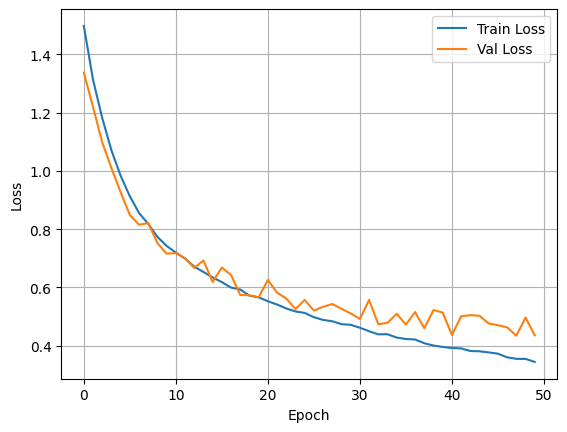

In [ ]:
plot_loss(history)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=16,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[print_metrics_callback])

# Evaluate the model on test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print performance metrics
print(classification_report(y_test, y_pred_binary))
print("AUC Score:", roc_auc_score(y_test, y_pred))

Epoch 1/50
224/225 [============================>.] - ETA: 0s - loss: 0.3404 - accuracy: 0.8842 - auc: 0.9502 - prc: 0.8748
Epoch: 1
Train Loss: 0.34012481570243835
Val Loss: 0.44680255651474
Train Accuracy: 0.8841666579246521
Val Accuracy: 0.8125
225/225 [==============================] - 3s 9ms/step - loss: 0.3401 - accuracy: 0.8842 - auc: 0.9502 - prc: 0.8745 - val_loss: 0.4468 - val_accuracy: 0.8125 - val_auc: 0.8442 - val_prc: 0.7335
Epoch 2/50
222/225 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8874 - auc: 0.9518 - prc: 0.8812
Epoch: 2
Train Loss: 0.3362373113632202
Val Loss: 0.4661586284637451
Train Accuracy: 0.8872222304344177
Val Accuracy: 0.8100000023841858
225/225 [==============================] - 2s 11ms/step - loss: 0.3362 - accuracy: 0.8872 - auc: 0.9519 - prc: 0.8830 - val_loss: 0.4662 - val_accuracy: 0.8100 - val_auc: 0.8443 - val_prc: 0.7348
Epoch 3/50
224/225 [============================>.] - ETA: 0s - loss: 0.3321 - accuracy: 0.8895 - au

In [ ]:

def tuner_make_model(hp,  metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = keras.initializers.Constant(output_bias)
  model = keras.Sequential()
  model.add(Dense(
      hp.Choice('units', [128,256,512]),
      activation='relu')
  )
  model.add(keras.layers.Dropout( 0.5))

  model.add(Dense(
      hp.Choice('units', [64,32]),
      activation='relu')
  )
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias))
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 4e-4,5e-5,6e-6])),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model


In [ ]:
hp = keras_tuner.HyperParameters()
class MyTuner(keras_tuner.tuners.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):

    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size',
                                         values=[4,8,16],
                                         default=8)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)


tuner = MyTuner(
    tuner_make_model,
    max_trials=20,
    # Do not resume the previous search in the same directory.
    overwrite=False,
    # Pick the best model based on validation accuracy
    objective=keras_tuner.Objective("val_auc", direction="max"),
    # Set a directory to store the intermediate results.
    directory="/tuner",
    )

tuner.search(X_train, y_train, epochs=100, validation_split=0.1)


Trial 20 Complete [00h 04m 22s]
val_auc: 0.8571532964706421

Best val_auc So Far: 0.8624708652496338
Total elapsed time: 03h 53m 18s


In [ ]:
best_hparams = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(best_hparams.values)

Best Hyperparameters:
{'units': 128, 'learning_rate': 0.0004, 'batch_size': 4}


In [ ]:
128 4e-4 4